# How to use the GAM class


In [1]:
from GAM_torch import GAM
import torch
from sklearn.model_selection import train_test_split
from utils import compute_nonzeros, add_intercept
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['FOR_DISABLE_CONSOLE_CTRL_HANDLER'] = '1'
torch.set_printoptions(sci_mode=False)

In [2]:
# Define non-parametric functions for simulation

def f1(x: torch.Tensor):
    return -5 * torch.sin(3 * x)

def f2(x: torch.Tensor):
    return -(2 * (1 - x ** 2) * np.exp(3 * x) - 2)

def f3(x: torch.Tensor):
    return -(-4 * x ** 4 + 9.33 * x ** 3 + 5 * x ** 2 - 8.33 * x)

In [3]:
# function to generate simulated data
def generate_data(n: int, p: int, data_class: str, fs: list, seed: int, lb: float, ub: float, cor: float = 0):
    """generate data"""
    torch.manual_seed(seed)
    t = np.sqrt(cor / (1 - cor))
    if lb > ub:
        lb, ub = ub, lb
    rg = ub - lb
    shift = 0.5 - (ub + lb) / 2 / rg
    x = (torch.rand([n, p]) - shift) * rg
    u = (torch.rand([n, 1]) - shift) * rg
    #x = torch.where(torch.abs(x) > 1, torch.sign(x), x)
    x = (x + t * u) / np.sqrt(1 + t ** 2)
    eta = None
    for i in range(len(fs)):
        if eta is None:
            eta = fs[i](x[:, i])
        else:
            eta += fs[i](x[:, i])
    if data_class == 'regression':
        y = eta + torch.randn([n])
    elif data_class == 'classification':
        eta = torch.exp(eta) / (1 + torch.exp(eta))
        y = torch.bernoulli(eta)
    elif data_class == 'poisson':
        eta = torch.exp(eta)
        y = torch.poisson(eta)
    elif data_class == 'gamma':
        eta = torch.exp(-eta)
        y = torch.distributions.gamma.Gamma(eta, 1).sample()
    return x, y


In [14]:
degree = 3
df = 9
data_class = 'classification'
n = 100
p = 200

In [15]:
# generate train, test data. Spline is not stable outside of edge knots, here for demonstration purposes, we generate testing
# data within the range of training  data. In practice, it's ok to temporarily extend edge knots when data are out of range.
fs = [f1, f2, f3]
seed = 666
x_train, y_train = generate_data(n, p, data_class, fs, seed, -1, 1, cor=0)
lb, ub = max(x_train.numpy().min(axis=0)), min(x_train.numpy().max(axis=0))
x_test, y_test = generate_data(5000, p, data_class, fs, seed, lb, ub, cor=0)

In [16]:
# fit_2 fits the two-step approach, now we look at the case when there is no smoothness penalty
model = GAM(tol=1e-2, df=df, data_class=data_class, degree=degree)
result1 = model.fit_2(x_train, y_train, num_lams=50, smooth=0.0)
y_predict = model.predict(x_test)

Fitted lam = 0.040956515818834305, 0 nonzero variables [0]
Fitted lam = 0.040120668557225445, 0 nonzero variables [0]
Fitted lam = 0.03928482129561658, 0 nonzero variables [0]
Fitted lam = 0.03844897403400772, 0 nonzero variables [0]
Fitted lam = 0.03761312677239885, 0 nonzero variables [0]
Fitted lam = 0.03677727951078999, 0 nonzero variables [0]
Fitted lam = 0.03594143224918112, 0 nonzero variables [0]
Fitted lam = 0.03510558498757226, 0 nonzero variables [0]
Fitted lam = 0.0342697377259634, 0 nonzero variables [0]
Fitted lam = 0.033433890464354535, 1 nonzero variables [0, 1]
Fitted lam = 0.032598043202745675, 1 nonzero variables [0, 1]

C:\Users\kaixu\Dropbox\research\PenalizedGAM\utils.py:42: UserWarning: Looks like intercept is already included, nothing has been added.
  warn("Looks like intercept is already included, nothing has been added.")



Fitted lam = 0.03176219594113681, 1 nonzero variables [0, 1]
Fitted lam = 0.030926348679527947, 1 nonzero variables [0, 1]
Fitted lam = 0.030090501417919083, 1 nonzero variables [0, 1]
Fitted lam = 0.02925465415631022, 1 nonzero variables [0, 1]
Fitted lam = 0.028418806894701356, 1 nonzero variables [0, 1]
Fitted lam = 0.027582959633092492, 1 nonzero variables [0, 1]
Fitted lam = 0.02674711237148363, 1 nonzero variables [0, 1]
Fitted lam = 0.025911265109874765, 1 nonzero variables [0, 1]
Fitted lam = 0.0250754178482659, 2 nonzero variables [0, 1, 2]
Fitted lam = 0.024239570586657037, 2 nonzero variables [0, 1, 2]
Fitted lam = 0.023403723325048174, 2 nonzero variables [0, 1, 2]
Fitted lam = 0.02256787606343931, 2 nonzero variables [0, 1, 2]
Fitted lam = 0.02173202880183045, 2 nonzero variables [0, 1, 2]
Fitted lam = 0.020896181540221586, 2 nonzero variables [0, 1, 2]
Fitted lam = 0.020060334278612722, 2 nonzero variables [0, 1, 2]
Fitted lam = 0.01922448701700386, 2 nonzero variables [

In [7]:
print(f"The testing accuracy is {1 - torch.mean(torch.abs(y_predict.squeeze() - y_test.squeeze()))}")


The testing accuracy is 0.8392000198364258


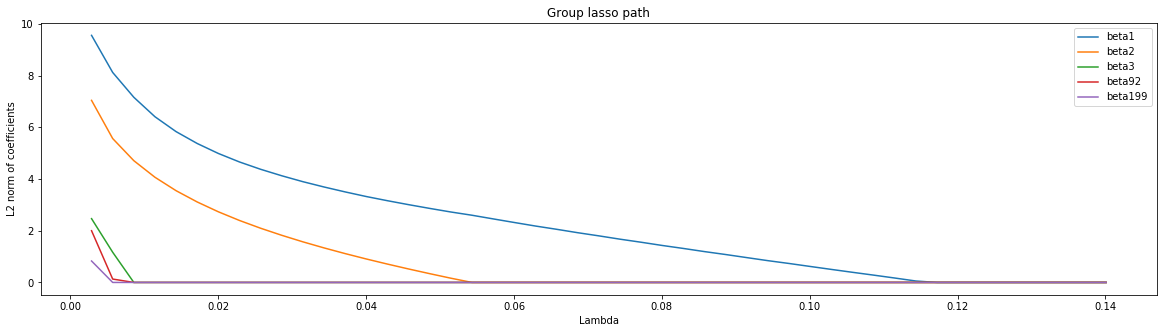

In [8]:
# plot solution path
model.plot_solution_path()

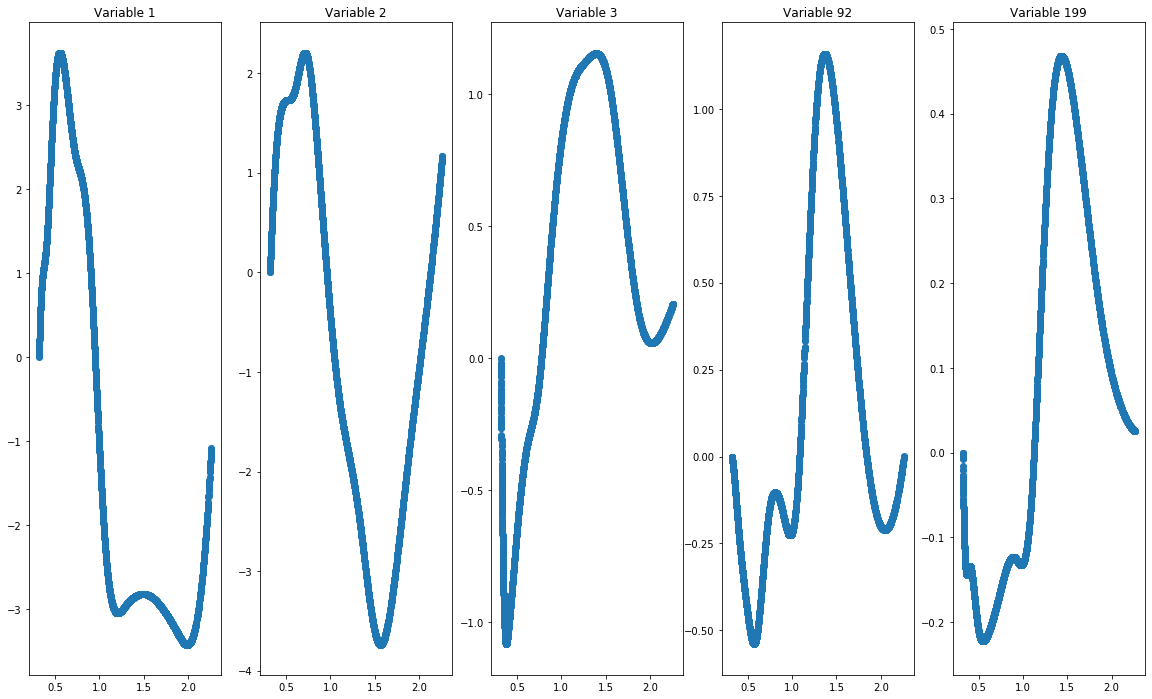

In [9]:
# plot estimated functions
model.plot_functions(x_test)

In [10]:
# fit_2 fits the two-step approach, add smoothness penalty
model = GAM(tol=1e-2, df=df, data_class=data_class, degree=degree)
result1 = model.fit_2(x_train, y_train, num_lams=50, smooth=0.05)
y_predict = model.predict(x_test)

Fitted lam = 0.032178379595279694, 0 nonzero variables [0]
Fitted lam = 0.03152167797088623, 0 nonzero variables [0]
Fitted lam = 0.030864976346492767, 0 nonzero variables [0]
Fitted lam = 0.030208274722099304, 0 nonzero variables [0]
Fitted lam = 0.02955157309770584, 0 nonzero variables [0]
Fitted lam = 0.028894871473312378, 0 nonzero variables [0]
Fitted lam = 0.028238169848918915, 0 nonzero variables [0]
Fitted lam = 0.02758146822452545, 0 nonzero variables [0]
Fitted lam = 0.02692476660013199, 0 nonzero variables [0]
Fitted lam = 0.026268064975738525, 1 nonzero variables [0, 1]
Fitted lam = 0.025611363351345062, 1 nonzero variables [0, 1]


C:\Users\kaixu\Dropbox\research\PenalizedGAM\utils.py:42: UserWarning: Looks like intercept is already included, nothing has been added.
  warn("Looks like intercept is already included, nothing has been added.")


Fitted lam = 0.0249546617269516, 1 nonzero variables [0, 1]
Fitted lam = 0.024297960102558136, 1 nonzero variables [0, 1]
Fitted lam = 0.023641258478164673, 1 nonzero variables [0, 1]
Fitted lam = 0.02298455685377121, 1 nonzero variables [0, 1]
Fitted lam = 0.022327855229377747, 1 nonzero variables [0, 1]
Fitted lam = 0.021671153604984283, 1 nonzero variables [0, 1]
Fitted lam = 0.02101445198059082, 1 nonzero variables [0, 1]
Fitted lam = 0.020357750356197357, 1 nonzero variables [0, 1]
Fitted lam = 0.019701048731803894, 2 nonzero variables [0, 1, 2]
Fitted lam = 0.01904434710741043, 2 nonzero variables [0, 1, 2]
Fitted lam = 0.018387645483016968, 2 nonzero variables [0, 1, 2]
Fitted lam = 0.017730943858623505, 2 nonzero variables [0, 1, 2]
Fitted lam = 0.01707424223423004, 2 nonzero variables [0, 1, 2]
Fitted lam = 0.01641754060983658, 2 nonzero variables [0, 1, 2]
Fitted lam = 0.015760838985443115, 2 nonzero variables [0, 1, 2]
Fitted lam = 0.015104137361049652, 2 nonzero variables [

In [11]:
print(f"The testing accuracy is {1 - torch.mean(torch.abs(y_predict.squeeze() - y_test.squeeze()))}")

The testing accuracy is 0.847599983215332


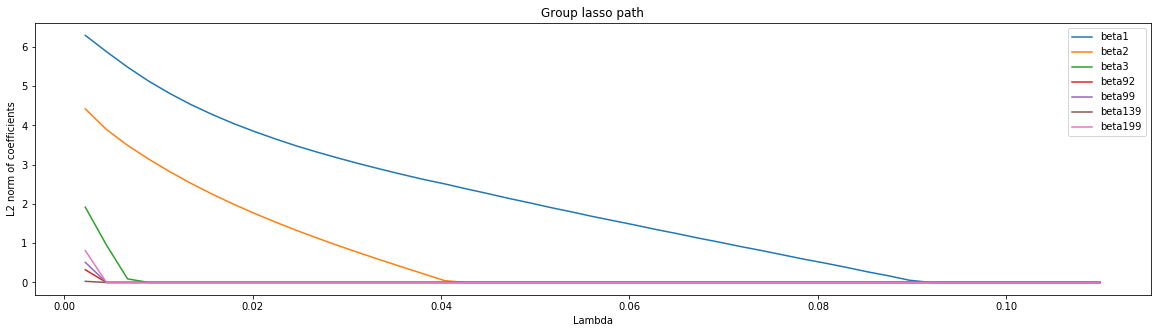

In [12]:
# plot solution path
model.plot_solution_path()

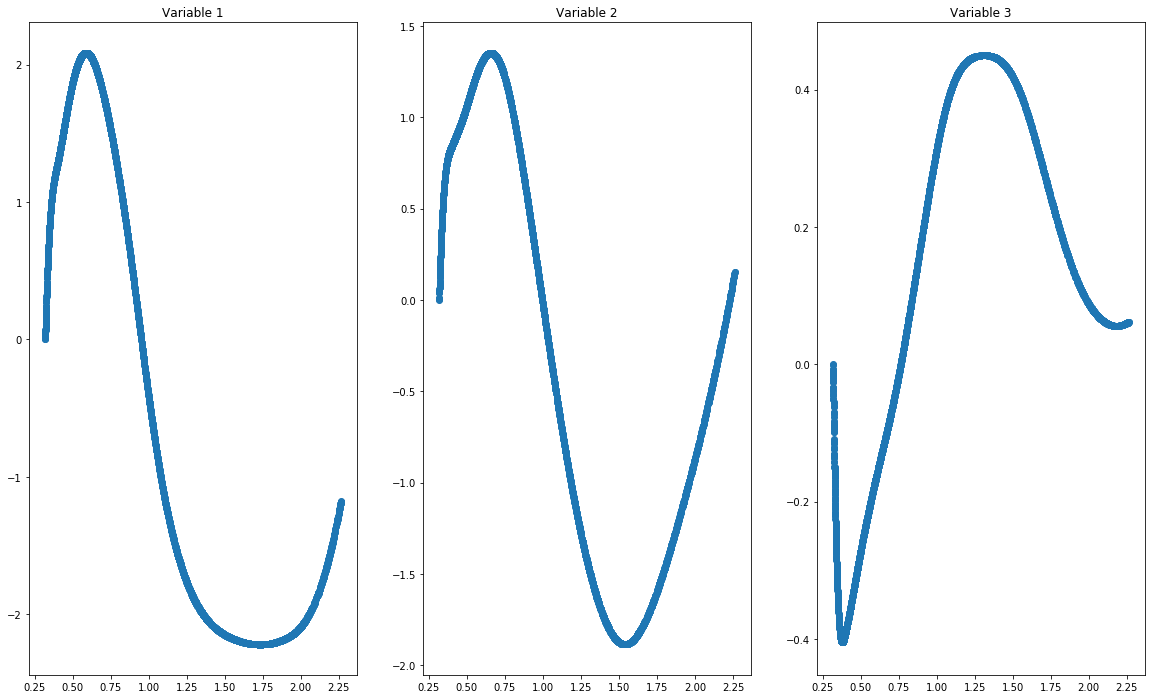

In [13]:
# plot estimated functions
model.plot_functions(x_test)